In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

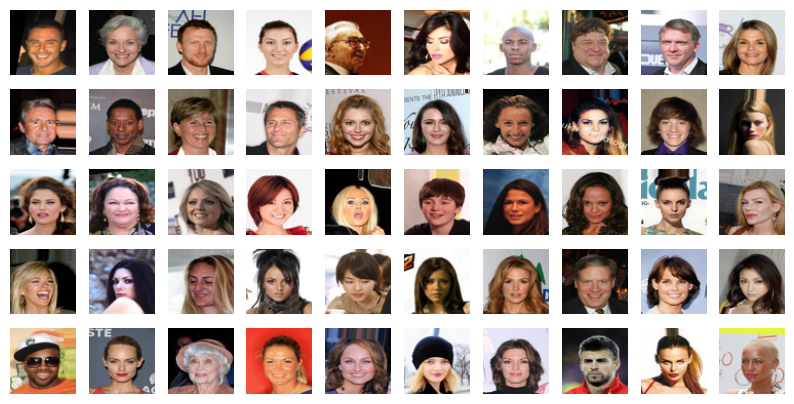

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
import torchvision

#使用预训练的模型作为encoder,并且不再训练它的参数
encoder = torchvision.models.regnet_y_800mf(weights='IMAGENET1K_V2')

encoder.fc = torch.nn.BatchNorm1d(num_features=784)

encoder(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 784])

In [5]:
class Decoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        def block(in_channels,
                  out_channels,
                  kernel_size=5,
                  stride=2,
                  padding=1,
                  dropout=True):

            sequential = [
                torch.nn.Conv2d(in_channels=in_channels,
                                out_channels=in_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                torch.nn.LeakyReLU(),
                torch.nn.ConvTranspose2d(in_channels=in_channels,
                                         out_channels=out_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding),
                torch.nn.BatchNorm2d(num_features=out_channels),
                torch.nn.LeakyReLU(),
            ]

            if dropout:
                sequential.append(torch.nn.Dropout(p=0.2))

            return torch.nn.Sequential(*sequential)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=784, out_features=512 * 4 * 4),
            torch.nn.BatchNorm1d(num_features=512 * 4 * 4),
            torch.nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),
            block(512, 256),
            block(256, 128),
            block(128, 64),
            block(64, 3, dropout=False),
            torch.nn.UpsamplingNearest2d(size=64),
            torch.nn.Conv2d(in_channels=3,
                            out_channels=3,
                            kernel_size=1,
                            stride=1,
                            padding=0),
            torch.nn.Tanh(),
        )

        #两个全连接层
        self.fc_mu = torch.nn.Linear(784, 784)
        self.fc_log_var = torch.nn.Linear(784, 784)

    def forward(self, hidden):
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        randn = torch.randn(mu.shape, device=hidden.device)
        hidden = mu + (log_var / 2).exp() * randn

        return self.decoder(hidden), mu, log_var


decoder = Decoder()

pred, mu, log_var = decoder(torch.randn(2, 784))

pred.shape, mu.shape, log_var.shape

(torch.Size([2, 3, 64, 64]), torch.Size([2, 784]), torch.Size([2, 784]))

In [6]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=2e-4)
criterion = torch.nn.MSELoss(reduction='none')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
decoder.to(device)

encoder.eval()
for param in encoder.parameters():
    param.requires_grad_(False)

decoder.train()

device

'cuda'

0 4495.07568359375


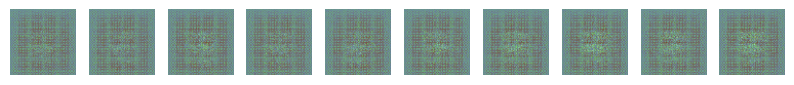

50 1745.7108154296875


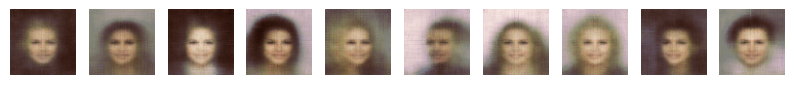

100 1386.504638671875


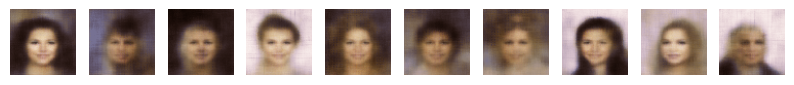

150 963.2528076171875


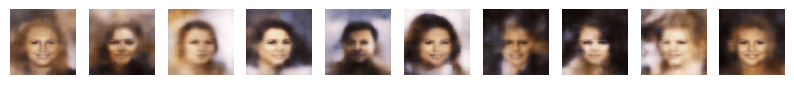

200 802.7899780273438


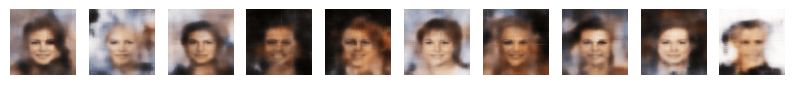

250 673.9788818359375


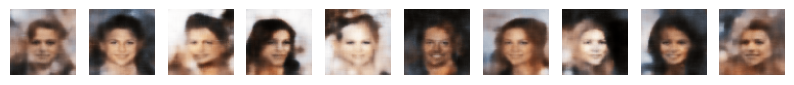

300 623.361572265625


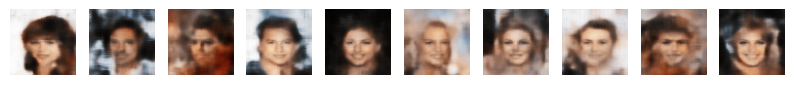

350 590.5452880859375


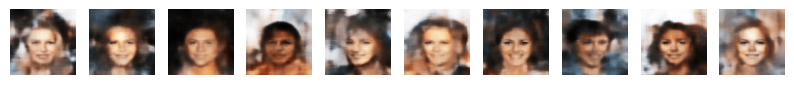

400 485.30621337890625


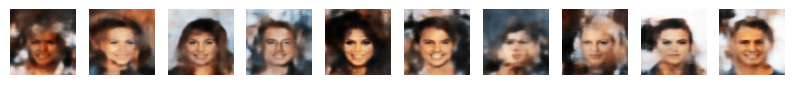

450 437.50567626953125


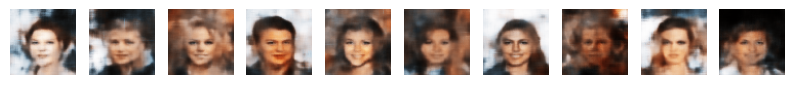

500 399.887939453125


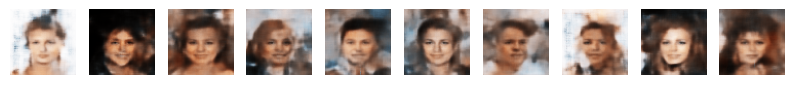

550 397.86810302734375


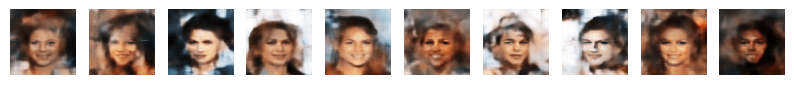

600 374.3244323730469


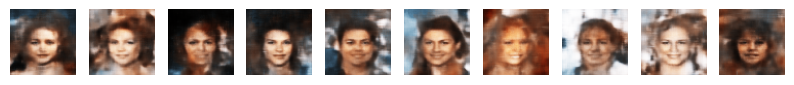

650 336.75274658203125


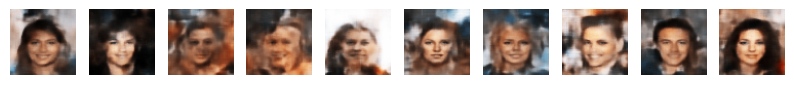

700 325.2977600097656


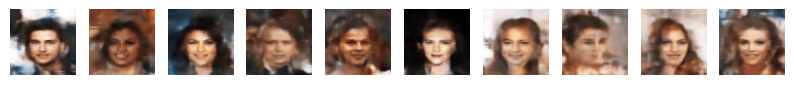

750 302.19915771484375


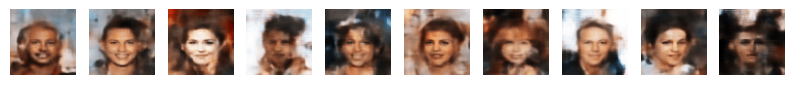

800 327.8619384765625


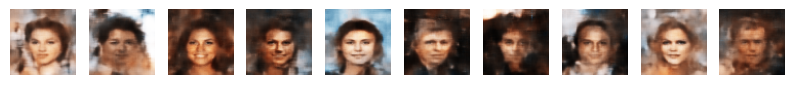

850 294.06884765625


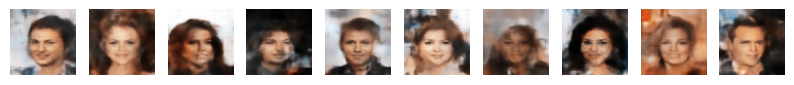

900 298.7232666015625


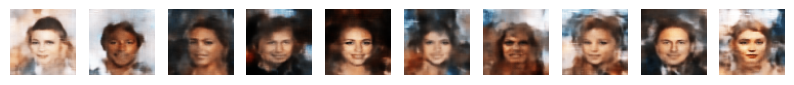

950 264.8293762207031


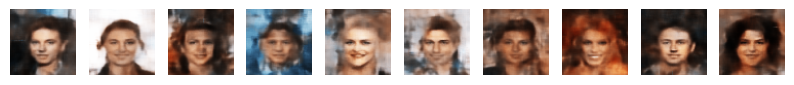

In [7]:
def train():
    for epoch in range(1000):
        for _, data in enumerate(loader):
            data = data.to(device)

            with torch.no_grad():
                #[b, 3, 64, 64] -> [b, 784]
                hidden = encoder(data)

            #[b, 784] -> [b, 3, 64, 64],[b, 784],[b, 784]
            pred, mu, log_var = decoder(hidden)

            loss_mse = criterion(pred, data) * 10000
            loss_mse = loss_mse.mean(dim=(1, 2, 3))

            loss_kl = 1 + log_var - mu**2 - log_var.exp()
            loss_kl = loss_kl.sum(dim=1) * -0.5

            loss = (loss_mse + loss_kl).mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 50 == 0:
            print(epoch, loss.item())

            with torch.no_grad():
                gen, _, _ = decoder(torch.randn(10, 784, device=device))
            show(gen)


local_training = True

if local_training:
    train()

In [8]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.decoder = decoder.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.2.vae',
        use_auth_token=open('/root/hub_token.txt').read().strip())

pytorch_model.bin:   0%|          | 0.00/60.6M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

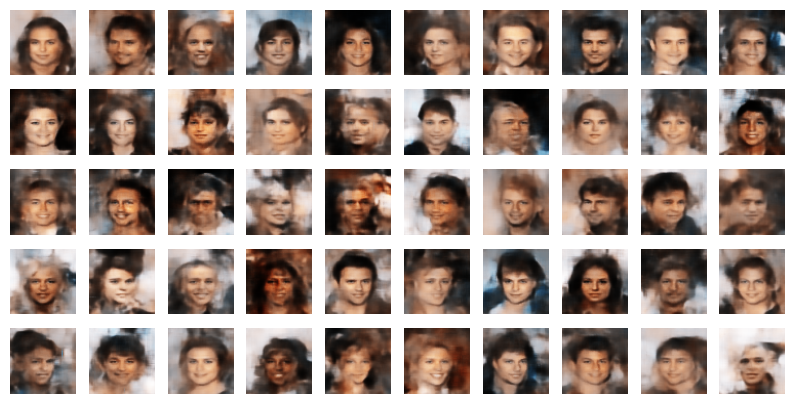

In [9]:
#加载训练好的模型
decoder = Model.from_pretrained('lansinuote/gen.2.vae').decoder

with torch.no_grad():
    gen, _, _ = decoder(torch.randn(50, 784))
    
show(gen)